# Using only level3 data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
drive_root = '/gdrive/My\ Drive/'

Mounted at /gdrive


In [ ]:
%cd $drive_root
%cd patches

/gdrive/My Drive
/gdrive/My Drive/patches


In [ ]:
!ls

tumor_001.tif  tumor_016.tif  tumor_075.tif  tumor_091.tif  tumor_101.tif
tumor_002.tif  tumor_031.tif  tumor_078.tif  tumor_094.tif
tumor_012.tif  tumor_064.tif  tumor_084.tif  tumor_096.tif


In [ ]:
import tensorflow as tf

## Preprocess Image

In [ ]:
def process_img(img_path, label):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.float32)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, label

## Show one example of processed image

In [ ]:
processed_img, label = process_img("tumor_001.tif/level1/positive/patch_0.jpeg", 1.0)

In [ ]:
import matplotlib.pyplot as plt

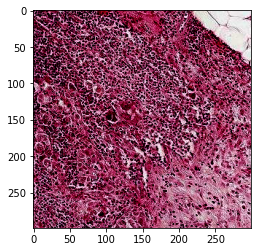

In [ ]:
plt.imshow(processed_img)

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
from os import listdir
import numpy as np

In [ ]:
slide_paths = listdir('.')
# remove the two negative slides from training
slide_paths.remove('tumor_002.tif')
slide_paths.remove('tumor_012.tif')
neg_slide_paths = ['tumor_002.tif', 'tumor_012.tif']

In [ ]:
len(slide_paths)

11

## Make directories to store the augmented/rotated images

In [ ]:
# make directories for augmented images
for slide_path in slide_paths:
  %mkdir $slide_path/level1_aug
  %mkdir $slide_path/level2_aug
  %mkdir $slide_path/level1_aug/positive
  %mkdir $slide_path/level2_aug/positive

## Data Augmentation: rotations by 90, 180, 270 degrees

In [ ]:
import tensorflow_addons as tfa
import math
from PIL import Image
# augment and save
# augmented by rotating counter-clock-wise 90, 180, 270
def data_augmentation(slide_path):
  # level1
  for img_path in listdir(f'{slide_path}/level1/positive'):
    img = tf.io.read_file(f'{slide_path}/level1/positive/{img_path}')
    img = tf.image.decode_jpeg(img, channels=3)
    img1 = tfa.image.rotate(img, 90 * math.pi / 180).numpy()
    img2 = tfa.image.rotate(img, 180 * math.pi / 180).numpy()
    img3 = tfa.image.rotate(img, 270 * math.pi / 180).numpy()
    img1 = Image.fromarray(img1).convert('RGB')
    img2 = Image.fromarray(img2).convert('RGB')
    img3 = Image.fromarray(img3).convert('RGB')
    img_name, img_ext = img_path.split('.')
    img1.save(f'{slide_path}/level1_aug/positive/{img_name}_aug1.{img_ext}')
    img2.save(f'{slide_path}/level1_aug/positive/{img_name}_aug2.{img_ext}')
    img3.save(f'{slide_path}/level1_aug/positive/{img_name}_aug3.{img_ext}')
  # level2
  for img_path in listdir(f'{slide_path}/level2/positive'):
    img = tf.io.read_file(f'{slide_path}/level2/positive/{img_path}')
    img = tf.image.decode_jpeg(img, channels=3)
    img1 = tfa.image.rotate(img, 90 * math.pi / 180).numpy()
    img2 = tfa.image.rotate(img, 180 * math.pi / 180).numpy()
    img3 = tfa.image.rotate(img, 270 * math.pi / 180).numpy()
    img1 = Image.fromarray(img1).convert('RGB')
    img2 = Image.fromarray(img2).convert('RGB')
    img3 = Image.fromarray(img3).convert('RGB')
    img_name, img_ext = img_path.split('.')
    img1.save(f'{slide_path}/level2_aug/positive/{img_name}_aug1.{img_ext}')
    img2.save(f'{slide_path}/level2_aug/positive/{img_name}_aug2.{img_ext}')
    img3.save(f'{slide_path}/level2_aug/positive/{img_name}_aug3.{img_ext}')

In [ ]:
for slide_path in slide_paths:
  data_augmentation(slide_path)

## Show the number of positives and negatives for each slide.

In [ ]:
for slide_path in slide_paths:
  n_neg = len(listdir(f'{slide_path}/level1/negative'))
  n_pos = len(listdir(f'{slide_path}/level1/positive')) + len(listdir(f'{slide_path}/level1_aug/positive'))
  print(f"{slide_path}, neg {n_neg}, pos {n_pos}")

tumor_001.tif, neg 501, pos 20
tumor_016.tif, neg 208, pos 156
tumor_031.tif, neg 132, pos 188
tumor_064.tif, neg 212, pos 148
tumor_075.tif, neg 223, pos 104
tumor_084.tif, neg 327, pos 60
tumor_091.tif, neg 196, pos 64
tumor_094.tif, neg 649, pos 60
tumor_096.tif, neg 489, pos 80
tumor_101.tif, neg 462, pos 240
tumor_078.tif, neg 464, pos 996


### Training slides: 'tumor_031.tif', 'tumor_064.tif', 'tumor_075.tif', 'tumor_101.tif', 'tumor_084.tif', 'tumor_078.tif'
### Validation slides: 'tumor_091.tif' , 'tumor_016.tif'
### Test slides: 'tumor_096.tif', 'tumor_094.tif', 'tumor_001.tif'

### Balancing data: randomly select negatives samples so that the number of positive samples equals the number of negative samples

In [ ]:
n_all = len(slide_paths)
n_train = 5
n_val = 2
n_test = 3

In [ ]:
slide_paths_train = ['tumor_031.tif', 'tumor_064.tif', 'tumor_075.tif', 'tumor_101.tif', 'tumor_084.tif', 'tumor_078.tif']
slide_paths_val = ['tumor_091.tif' , 'tumor_016.tif']
slide_paths_test = ['tumor_096.tif', 'tumor_094.tif', 'tumor_001.tif']

In [ ]:
# train
train_data1 = []
train_labels1 = []
for slide_path in slide_paths_train:
  negative1 = listdir(f'{slide_path}/level1/negative')
  negative1 = [f'{slide_path}/level1/negative/'+neg for neg in negative1]
  positive1 = listdir(f'{slide_path}/level1/positive')
  positive1 = [f'{slide_path}/level1/positive/'+pos for pos in positive1]
  # adding augmentation
  positive1_aug = listdir(f'{slide_path}/level1_aug/positive')
  positive1_aug = [f'{slide_path}/level1_aug/positive/'+pos for pos in positive1_aug]
  positive1 = positive1 + positive1_aug
  # randomly pick positives that equal to the size of negatives
  n_pos = len(positive1)
  n_neg = len(negative1)
  neg_data = list(np.random.choice(negative1, size=min(n_pos, n_neg), replace=False))
  pos_data = positive1
  # update
  train_data1 += pos_data
  train_data1 += neg_data
  train_labels1 += [1.0 for i in range(len(pos_data))]
  train_labels1 += [0.0 for i in range(len(neg_data))]

In [ ]:
# val
val_data1 = []
val_labels1 = []
for slide_path in slide_paths_val:
  negative1 = listdir(f'{slide_path}/level1/negative')
  negative1 = [f'{slide_path}/level1/negative/'+neg for neg in negative1]
  positive1 = listdir(f'{slide_path}/level1/positive')
  positive1 = [f'{slide_path}/level1/positive/'+pos for pos in positive1]
  # adding augmentation
  positive1_aug = listdir(f'{slide_path}/level1_aug/positive')
  positive1_aug = [f'{slide_path}/level1_aug/positive/'+pos for pos in positive1_aug]
  positive1 = positive1 + positive1_aug
  # randomly pick positives that equal to the size of negatives
  n_pos = len(positive1)
  n_neg = len(negative1)
  neg_data = list(np.random.choice(negative1, size=min(n_pos, n_neg), replace=False))
  pos_data = positive1
  # update
  val_data1 += pos_data
  val_data1 += neg_data
  val_labels1 += [1.0 for i in range(len(pos_data))]
  val_labels1 += [0.0 for i in range(len(neg_data))]

In [ ]:
# test
test_data1 = []
test_labels1 = []
for slide_path in slide_paths_test:
  negative1 = listdir(f'{slide_path}/level1/negative')
  negative1 = [f'{slide_path}/level1/negative/'+neg for neg in negative1]
  positive1 = listdir(f'{slide_path}/level1/positive')
  positive1 = [f'{slide_path}/level1/positive/'+pos for pos in positive1]
  # adding augmentation
  positive1_aug = listdir(f'{slide_path}/level1_aug/positive')
  positive1_aug = [f'{slide_path}/level1_aug/positive/'+pos for pos in positive1_aug]
  positive1 = positive1 + positive1_aug
  # randomly pick positives that equal to the size of negatives
  n_pos = len(positive1)
  n_neg = len(negative1)
  neg_data = list(np.random.choice(negative1, size=min(n_pos, n_neg), replace=False))
  pos_data = positive1
  # update
  test_data1 += pos_data
  test_data1 += neg_data
  test_labels1 += [1.0 for i in range(len(pos_data))]
  test_labels1 += [0.0 for i in range(len(neg_data))]

In [ ]:
print(len(train_data1))
print(len(val_data1))
print(len(test_data1))

2884
440
320


### Make tf.Dataset for training, val, test

In [ ]:
TRAIN_SIZE = len(train_data1)
rand_ind = np.random.choice([i for i in range(len(train_data1))], size=TRAIN_SIZE, replace=False)
train_dataset1 = tf.data.Dataset.from_tensor_slices(([train_data1[i] for i in rand_ind], [train_labels1[i] for i in rand_ind]))

train_dataset1 = train_dataset1.map(
  process_img, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset1 = train_dataset1.shuffle(1000).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
VAL_SIZE = len(val_data1)
rand_ind = np.random.choice([i for i in range(len(val_data1))], size=VAL_SIZE, replace=False)
val_dataset1 = tf.data.Dataset.from_tensor_slices(([val_data1[i] for i in rand_ind], [val_labels1[i] for i in rand_ind]))

val_dataset1 = val_dataset1.map(
  process_img, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_dataset1 = val_dataset1.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
TEST_SIZE = len(test_data1)
rand_ind = np.random.choice([i for i in range(len(test_data1))], size=TEST_SIZE, replace=False)
test_dataset1 = tf.data.Dataset.from_tensor_slices(([test_data1[i] for i in rand_ind], [test_labels1[i] for i in rand_ind]))

test_dataset1 = test_dataset1.map(
  process_img, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dataset1 = test_dataset1.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Use Inception v3 and pretrained on imagenet

In [ ]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')

In [ ]:
input = base_model.input
output = base_model.output
output = GlobalAveragePooling2D()(output)
output = Dense(1, activation='sigmoid')(output)
model = Model(input, output)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
model.fit(train_dataset1, validation_data=val_dataset1, epochs=2, callbacks=[callback])

Epoch 1/2
91/91 [==============================] - 51s 477ms/step - loss: 0.0816 - accuracy: 0.9688 - val_loss: 1.3836 - val_accuracy: 0.7045
Epoch 2/2
91/91 [==============================] - 42s 451ms/step - loss: 0.0400 - accuracy: 0.9847 - val_loss: 0.2822 - val_accuracy: 0.9205


### Show an example of predicted probability on one patch

In [ ]:
processed_img, _ = process_img("tumor_101.tif/level1/negative/patch_1.jpeg", 1.0)
processed_img = tf.expand_dims(processed_img, axis=0)
prob = model.predict(processed_img)
prob

1/1 [==============================] - 1s 1s/step


array([[5.8348218e-05]], dtype=float32)

### ROC curve on test patches

In [ ]:
prediction = model.predict(test_dataset1)

10/10 [==============================] - 2s 117ms/step


In [ ]:
from sklearn import metrics

In [ ]:
true_labels = np.concatenate([y for x, y in test_dataset1], axis=0)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(true_labels, prediction, pos_label=1)

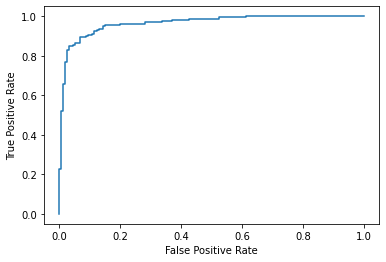

In [ ]:
disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
disp.plot()

### AUC score for test patches is 0.96.
### Test accuracy is 88.75%

In [ ]:
AUC = metrics.auc(fpr, tpr)
print(f'The AUC is {AUC:.2f}')

The AUC is 0.96


In [ ]:
_, acc = model.evaluate(test_dataset1)
print(f'Test accuracy is {acc*100:.2f}%')

10/10 [==============================] - 1s 117ms/step - loss: 0.4593 - accuracy: 0.8875
Test accuracy is 88.75%


### Store the optimal threshold.

In [ ]:
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
optimal_threshold

0.07102711

## Slide-level AUC score (as suggested in the paper)

### Here are 5 slides in test set, 3 positive and 2 negative

In [ ]:
slide_paths_test

['tumor_096.tif', 'tumor_094.tif', 'tumor_001.tif']

In [ ]:
test_paths_set = slide_paths_test + neg_slide_paths
test_paths_set

['tumor_096.tif',
 'tumor_094.tif',
 'tumor_001.tif',
 'tumor_002.tif',
 'tumor_012.tif']

### We tolerate 10 false-positives. So we pick the 10th largest probabilty of all patches in a slide as the slide's probability.

In [ ]:
# Take the max probablity of all patches in a slide as the slide's probability
slide_maxes = []
for slide_path in test_paths_set:
  negative1 = listdir(f'{slide_path}/level1/negative')
  negative1 = [f'{slide_path}/level1/negative/'+neg for neg in negative1]
  positive1 = listdir(f'{slide_path}/level1/positive')
  positive1 = [f'{slide_path}/level1/positive/'+pos for pos in positive1]

  neg_data = negative1
  pos_data = positive1

  test_data1 = pos_data + neg_data
  test_labels1 = [1.0 for i in range(len(pos_data))] + [0.0 for i in range(len(neg_data))]

  test_dataset1 = tf.data.Dataset.from_tensor_slices((test_data1, test_labels1))
  test_dataset1 = test_dataset1.map(
    process_img, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE)
  test_dataset1 = test_dataset1.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  pred = list(model.predict(test_dataset1))
  pred = [i[0] for i in pred]
  pred.sort(reverse=True)
  print(pred[:10])
  slide_maxes.append(pred[9])

16/16 [==============================] - 2s 118ms/step
[0.9998012, 0.999691, 0.99697626, 0.99570775, 0.99154156, 0.980864, 0.9740166, 0.96844226, 0.96593183, 0.9540555]
21/21 [==============================] - 3s 112ms/step
[0.99875736, 0.99678695, 0.99666387, 0.9965314, 0.99533796, 0.99232894, 0.9892162, 0.98915356, 0.9888742, 0.9883316]
16/16 [==============================] - 2s 112ms/step
[0.9999727, 0.9998647, 0.99892825, 0.9952962, 0.94159913, 0.92937976, 0.927026, 0.7170074, 0.67168146, 0.6458926]
7/7 [==============================] - 1s 111ms/step
[0.98451614, 0.9000713, 0.8726171, 0.8277417, 0.7725478, 0.7266102, 0.7034357, 0.53039986, 0.45111218, 0.43065897]
9/9 [==============================] - 1s 113ms/step
[0.93789995, 0.5153065, 0.16824575, 0.14523375, 0.11670994, 0.078587614, 0.07026554, 0.05696919, 0.053057645, 0.044320803]


In [ ]:
slide_maxes

[0.9540555, 0.9883316, 0.6458926, 0.43065897, 0.044320803]

### ROC curve for slide-level predictions.

In [ ]:
pred = slide_maxes
true = [1.0] * 3 + [0.0] * 2

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(true, pred, pos_label=1)

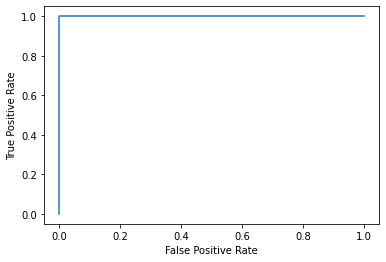

In [ ]:
disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
disp.plot()

### The slide-level AUC score is 1.00

In [ ]:
slide_AUC = metrics.auc(fpr, tpr)
print(f'The slide-level AUC is {slide_AUC:.2f}')

The slide-level AUC is 1.00


## Heat Map: for 3 positive slides in the test set.

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (548 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
from skimage.color import rgb2gray
import numpy as np
def find_tissue_percent(image, intensity=0.8):
    im_gray = rgb2gray(image)
    percent = np.sum(im_gray <= intensity) / (image.shape[0] * image.shape[1])
    return percent

# ignore the patch if more than 15% is non-tissue
def is_valid(image):
  tissue_percent = find_tissue_percent(image)
  if tissue_percent < 0.15:
    return False
  else:
    return True

In [ ]:
test_paths_set

['tumor_096.tif',
 'tumor_094.tif',
 'tumor_001.tif',
 'tumor_002.tif',
 'tumor_012.tif']

### Heat map for tumor_096: true mask vs heat map

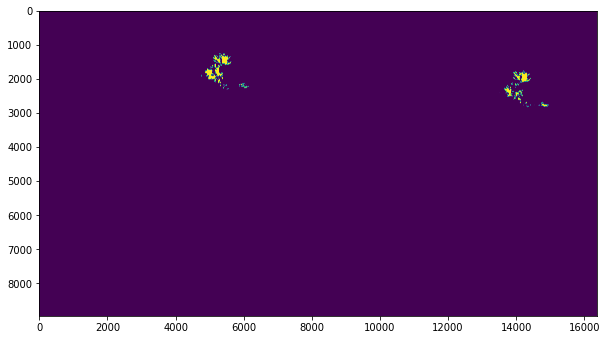

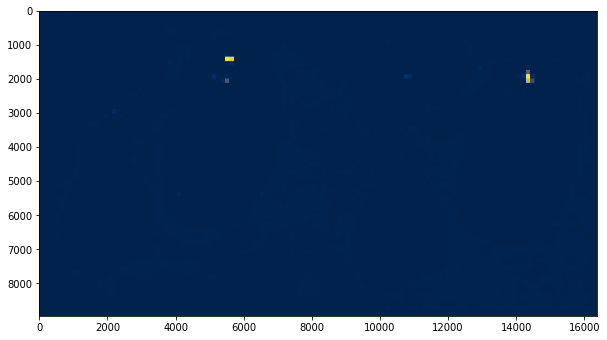

In [ ]:
# Heat map
from openslide import open_slide
import numpy as np

level = 3

test_path = test_paths_set[0]

slide = open_slide(f'../slides/{test_path}')
width = slide.level_dimensions[level][0]
height = slide.level_dimensions[level][1]

whole_region = read_slide(slide, x=int(0 * slide.level_downsamples[level]), y=int(0 * slide.level_downsamples[level]), level=level, width=width, height=height)
whole_region = tf.keras.applications.inception_v3.preprocess_input(whole_region)

heat_map = np.zeros((height, width))

# sliding window with stride 128
cur_width = 0
cur_height = 0

while cur_height+299 < height:
  cur_width = 0
  while cur_width+299 < width:
    region = whole_region[cur_height:cur_height+299, cur_width:cur_width+299, :]
    if is_valid(region):
      valid_region = tf.expand_dims(region, axis=0)
      prob = model.predict(valid_region, verbose=0)[0][0]
      # update center 128 region
      
      heat_map[cur_height+85:cur_height+213, cur_width+85:cur_width+213] = np.full((128, 128), prob)
    cur_width += 128
  cur_height += 128

prefix, suffix = test_path.split('.')
tumor_path = prefix + '_mask.' + suffix
tumor = open_slide(f'../slides/{tumor_path}')
tumor_region = read_slide(tumor, x=0, y=0, level=level, width=tumor.level_dimensions[level][0], height=tumor.level_dimensions[level][1])
tumor_region = tumor_region[:,:,0]
plt.figure(figsize=(10,10))
plt.imshow(tumor_region)
plt.figure(figsize=(10,10))
plt.imshow(heat_map, cmap='cividis')

### Heat map for tumor_094: true mask vs heat map

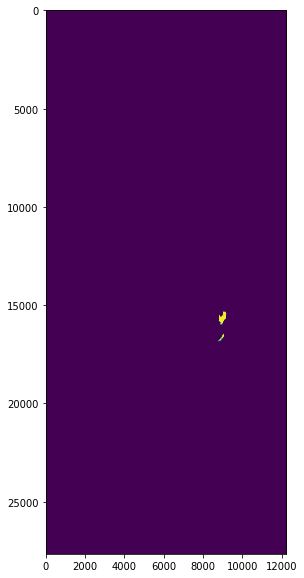

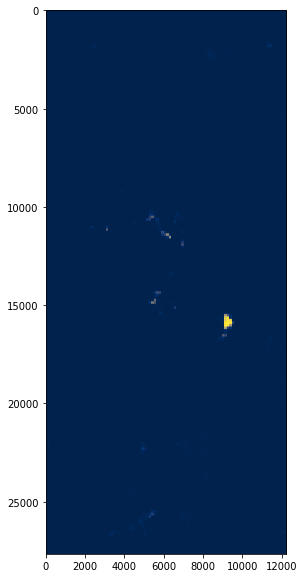

In [ ]:
test_path = test_paths_set[2]

slide = open_slide(f'../slides/{test_path}')
width = slide.level_dimensions[level][0]
height = slide.level_dimensions[level][1]

whole_region = read_slide(slide, x=int(0 * slide.level_downsamples[level]), y=int(0 * slide.level_downsamples[level]), level=level, width=width, height=height)
whole_region = tf.keras.applications.inception_v3.preprocess_input(whole_region)

heat_map_2 = np.zeros((height, width))

# sliding window with stride 128
cur_width = 0
cur_height = 0

while cur_height+299 < height:
  cur_width = 0
  while cur_width+299 < width:
    region = whole_region[cur_height:cur_height+299, cur_width:cur_width+299, :]
    if is_valid(region):
      valid_region = tf.expand_dims(region, axis=0)
      prob = model.predict(valid_region, verbose=0)[0][0]
      # update center 128 region
      heat_map_2[cur_height+85:cur_height+213, cur_width+85:cur_width+213] = np.full((128, 128), prob)
    cur_width += 128
  cur_height += 128

prefix, suffix = test_path.split('.')
tumor_path = prefix + '_mask.' + suffix
tumor = open_slide(f'../slides/{tumor_path}')
tumor_region_2 = read_slide(tumor, x=0, y=0, level=level, width=tumor.level_dimensions[level][0], height=tumor.level_dimensions[level][1])
tumor_region_2 = tumor_region_2[:,:,0]
plt.figure(figsize=(10,10))
plt.imshow(tumor_region_2)
plt.figure(figsize=(10,10))
plt.imshow(heat_map_2, cmap='cividis')

### Heat map for tumor_001: true mask vs heat map

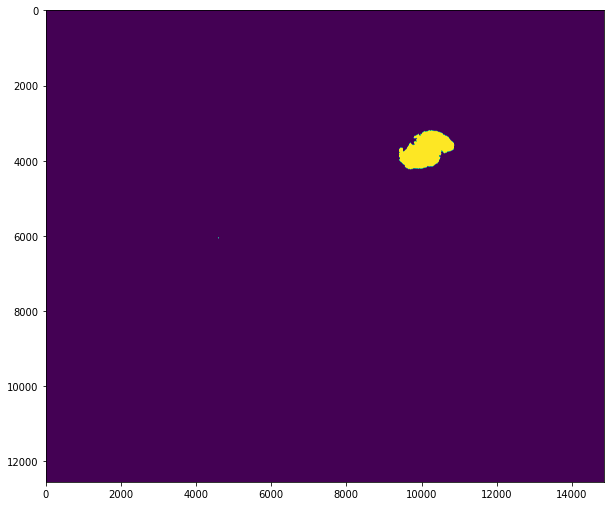

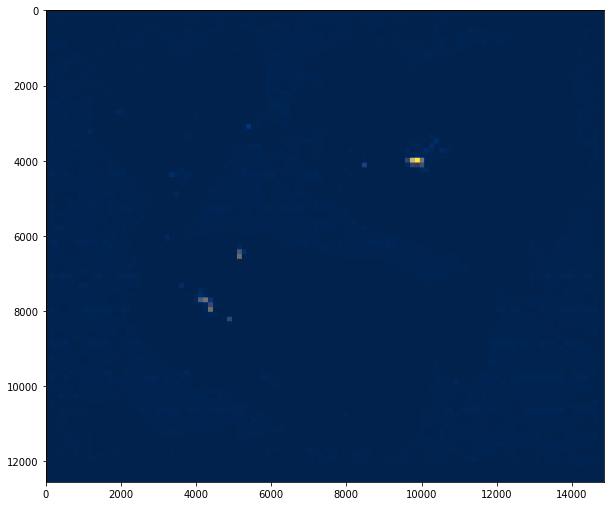

In [ ]:
test_path = test_paths_set[1]

slide = open_slide(f'../slides/{test_path}')
width = slide.level_dimensions[level][0]
height = slide.level_dimensions[level][1]

whole_region = read_slide(slide, x=int(0 * slide.level_downsamples[level]), y=int(0 * slide.level_downsamples[level]), level=level, width=width, height=height)
whole_region = tf.keras.applications.inception_v3.preprocess_input(whole_region)

heat_map_1 = np.zeros((height, width))

# sliding window with stride 128
cur_width = 0
cur_height = 0

while cur_height+299 < height:
  cur_width = 0
  while cur_width+299 < width:
    region = whole_region[cur_height:cur_height+299, cur_width:cur_width+299, :]
    if is_valid(region):
      valid_region = tf.expand_dims(region, axis=0)
      prob = model.predict(valid_region, verbose=0)[0][0]
      # update center 128 region
      heat_map_1[cur_height+85:cur_height+213, cur_width+85:cur_width+213] = np.full((128, 128), prob)
    cur_width += 128
  cur_height += 128

prefix, suffix = test_path.split('.')
tumor_path = prefix + '_mask.' + suffix
tumor = open_slide(f'../slides/{tumor_path}')
tumor_region_1 = read_slide(tumor, x=0, y=0, level=level, width=tumor.level_dimensions[level][0], height=tumor.level_dimensions[level][1])
tumor_region_1 = tumor_region_1[:,:,0]
plt.figure(figsize=(10,10))
plt.imshow(tumor_region_1)
plt.figure(figsize=(10,10))
plt.imshow(heat_map_1, cmap='cividis')